# Point Cloud Object Classification
This project is derived from the PointNet project by https://github.com/niconielsen32.
The main task of object classification is being done here by means of an artificial LiDAR point cloud synthesis.

### Installing dependencies

In [1]:
!pip install trimesh

In [2]:
!pip install tensorflow

  Using cached tensorflow-2.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
  Using cached protobuf-4.22.3-cp37-abi3-manylinux2014_x86_64.whl (302 kB)
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached wrapt-1.14.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (77 kB)
  Using cached h5py-3.8.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached grpcio-1.54.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.1 MB)
  Using cached libclang-16.0.0-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached jax-0.4.8-py3-none-any.whl
  Using cached tensorflow_estimator-2.12.0

In [3]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

2023-04-29 00:24:41.215378: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-29 00:24:41.218239: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 00:24:41.271049: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 00:24:41.272020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 00:24:42.111766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

The below code block facilitates using the GPU for training. However, the current notebook state did not have outputs by training computed on GPU.

In [4]:
#Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  0


IndexError: list index out of range

### Downloading the 3D objects which will be used for synthesizing LiDAR point clouds

In [5]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [6]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0003.off"))
mesh.show()

### Getting point cloud
Sampling of the 3d objects by, for instance 2048 samples and having a 3d subplot by scatter means gives us a close point cloud synthesis of the objects. For the requirement of training and predicting, since the dataset is the same the discrepancy in the number of samples per object does not matter here as compared to a real life LiDAR point cloud data. However, in the following sections noise has been added to better simulate one.

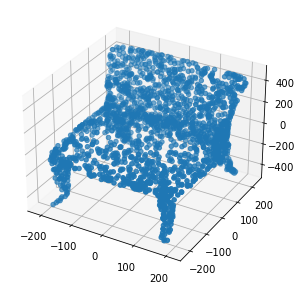

In [7]:
points = mesh.sample(2048)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
#ax.set_axis_off()
plt.show()

### Splitting into training and test data
The dataset needs to be split into training and test input and ground truth data.

In [8]:
def parse_dataset(num_points=2048):
    
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
    
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        #store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        #gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))
        
        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)
            
            
        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
            
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )
                                        

In [9]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: bathtub
processing class: bed
processing class: chair
processing class: desk
processing class: dresser
processing class: monitor
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


### Adding noise for accurate point cloud simulation

In [10]:
def augment(points, label):
    #jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    #shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))


train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

## Model building and architecture

In [11]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

High number of trainable parameters can lead to overfitting. Hence a regularization term being added - L2.

In [12]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
        
        
    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes = (2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

### Model description
The PointNet model has been used for classification. PointNet architecture has the advantage of being able to work with less voluminious modes of data directly from point cloud information as opposed to flattening of using 3d voxels in other models.
The PointNet model involves pose normalization as point clouds can consist of object data in various poses which should be detected. This is done by spatial transformations in a T-net subnetwork by a series of matrix multiplications.

A higher dimensional global feature vector is formed from the input to the output layers which, along with local point features, is directly used for classification. The local point features are used for segmentation. The global feature vector is formed from a set of points which define the object features since they pass through the max pooling layer, hence all lesser values have been neglected. And as long as they are lesser than the max value, they will not contribute to the global feature vector and hence will not play a role in defining the object.

Finally densely connected layers convert the global feature vector into probabilities of each class through softmax.

In [13]:
def tnet(inputs, num_features):
    
    #initialise bias on the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [14]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

### Model training

In [15]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20


2023-04-29 00:38:14.981570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3991]
	 [[{{node Placeholder/_1}}]]


125/125 [==============================] - ETA: 0s - loss: 3.5157 - sparse_categorical_accuracy: 0.2939

2023-04-29 00:39:26.222920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [908,2048,3]
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - 75s 533ms/step - loss: 3.5157 - sparse_categorical_accuracy: 0.2939 - val_loss: 928675558366117888.0000 - val_sparse_categorical_accuracy: 0.4185
Epoch 2/20
125/125 [==============================] - 66s 527ms/step - loss: 2.7784 - sparse_categorical_accuracy: 0.4848 - val_loss: 33038759936.0000 - val_sparse_categorical_accuracy: 0.4604
Epoch 3/20
125/125 [==============================] - 66s 527ms/step - loss: 2.5726 - sparse_categorical_accuracy: 0.5475 - val_loss: 210410833707008.0000 - val_sparse_categorical_accuracy: 0.5694
Epoch 4/20
125/125 [==============================] - 66s 528ms/step - loss: 2.4147 - sparse_categorical_accuracy: 0.5868 - val_loss: 18182590464.0000 - val_sparse_categorical_accuracy: 0.5033
Epoch 5/20
125/125 [==============================] - 66s 527ms/step - loss: 2.3489 - sparse_categorical_accuracy: 0.6204 - val_loss: 367731375341568.0000 - val_sparse_categorical_accuracy: 0.5452
Epoch 6/20
125/125 [===========

## Predicting Object classes on test data

2023-04-29 01:00:25.100565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [908]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 1s 806ms/step


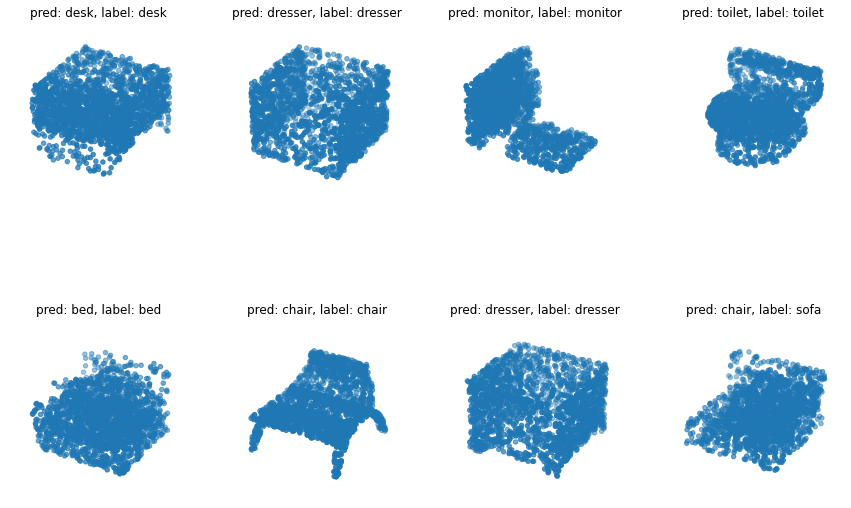

In [16]:
data = test_dataset.take(3)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

#plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1, projection = "3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

### References
https://github.com/niconielsen32/NeuralNetworks/blob/main/PointCloudPointNet.ipynb

https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a

https://doi.org/10.48550/arXiv.1612.00593
